In [197]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
!pip install ipython-autotime

%load_ext autotime

df = pd.read_csv('Breast_cancer_data.csv')
x = df.iloc[:,0:5]
sc_X = StandardScaler()
X_std = sc_X.fit_transform(x)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.37 s (started: 2022-06-10 13:05:34 +00:00)


In [198]:

train = df.sample(frac = 0.8, random_state = 1)
test = df.drop(train.index)

y_train = train["diagnosis"]
x_train = train.drop("diagnosis", axis = 1)

y_test = test["diagnosis"]
x_test = test.drop("diagnosis", axis = 1)

means = train.groupby(["diagnosis"]).mean() # Estimate mean of each class, feature
var = train.groupby(["diagnosis"]).var() # Estimate variance of each class, feature
prior = (train.groupby("diagnosis").count() / len(train)).iloc[:,1] # Estimate prior probabilities
classes = np.unique(train["diagnosis"].tolist()) # Storing all possible classes


def Normal(n, mu, var):
    
    # Function to return pdf of Normal(mu, var) evaluated at x
    sd = np.sqrt(var)
    pdf = (np.e ** (-0.5 * ((n - mu)/sd) ** 2)) / (sd * np.sqrt(2 * np.pi))
    
    return pdf

def Predict(X,x_tr):
    Predictions = []
    
    for i in X.index: # Loop through each instances
        
        ClassLikelihood = []
        instance = X.loc[i]
        
        for cls in classes: # Loop through each class
            
            FeatureLikelihoods = []
            FeatureLikelihoods.append(np.log(prior[cls])) # Append log prior of class 'cls'
            
            for col in x_tr.columns: # Loop through each feature
                
                data = instance[col]
                
                mean = means[col].loc[cls] # Find the mean of column 'col' that are in class 'cls'
                variance = var[col].loc[cls] # Find the variance of column 'col' that are in class 'cls'
                
                Likelihood = Normal(data, mean, variance)
                
                if Likelihood != 0:
                    Likelihood = np.log(Likelihood) # Find the log-likelihood evaluated at x
                else:
                    Likelihood = 1/len(train) 
                
                FeatureLikelihoods.append(Likelihood)
                
            TotalLikelihood = sum(FeatureLikelihoods) # Calculate posterior
            ClassLikelihood.append(TotalLikelihood)
            
        MaxIndex = ClassLikelihood.index(max(ClassLikelihood)) # Find largest posterior position
        Prediction = classes[MaxIndex]
        Predictions.append(Prediction)
        
    return Predictions

PredictTrain = Predict(x_train,x_train)
PredictTest = Predict(x_test,x_test)

time: 392 ms (started: 2022-06-10 13:05:38 +00:00)


In [199]:
def Accuracy(y, prediction):
    
    # Function to calculate accuracy
    y = list(y)
    prediction = list(prediction)
    score = 0
    
    for i, j in zip(y, prediction):
        if i == j:
            score += 1
            
    return score / len(y)

time: 4.97 ms (started: 2022-06-10 13:05:38 +00:00)


In [200]:
print(Accuracy(y_test, PredictTest))
print(confusion_matrix(y_test, PredictTest))
#print(accuracy_score(y_test, PredictTest))

0.8947368421052632
[[34 11]
 [ 1 68]]
time: 4.31 ms (started: 2022-06-10 13:05:38 +00:00)


In [201]:
cov_mat = np.cov(X_std.T)
eig_vals , eig_vecs = np.linalg.eig(cov_mat)
eig_pairs = [(np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]
print(eig_pairs)
eig_pairs.sort()
eig_pairs.reverse()
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)]
print(var_exp)

[(3.1779263772362496, array([0.55371341, 0.24687793, 0.55562001, 0.55179039, 0.1388039 ])), (0.00139760342213733, array([ 0.70990216,  0.00714976, -0.70359047, -0.01400078,  0.02742701])), (0.01662165450666038, array([-0.3987202 ,  0.00514554, -0.41807654,  0.81614814,  0.01048524])), (0.7899679994812961, array([-0.17451457,  0.80887797, -0.14438462, -0.17093468,  0.51497137])), (1.0228891822550665, array([-0.0026939 , -0.53356361,  0.02473754,  0.00385895,  0.84538499]))]
[63.44682538735288, 20.421829719538756, 15.771593100364715, 0.3318488492015147, 0.027902943542144225]
time: 9.83 ms (started: 2022-06-10 13:05:38 +00:00)


In [202]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(5,1),
                      eig_pairs[1][1].reshape(5,1),
                      eig_pairs[2][1].reshape(5,1)))
print(matrix_w)

[[ 0.55371341 -0.0026939  -0.17451457]
 [ 0.24687793 -0.53356361  0.80887797]
 [ 0.55562001  0.02473754 -0.14438462]
 [ 0.55179039  0.00385895 -0.17093468]
 [ 0.1388039   0.84538499  0.51497137]]
time: 3.43 ms (started: 2022-06-10 13:05:38 +00:00)


In [203]:
X_reduce = np.dot((X_std),matrix_w)
print(X_reduce)
print(type(X_reduce))

[[ 1.56207679  2.4644723  -1.4124361 ]
 [ 2.8010636  -0.46627365 -1.60092817]
 [ 2.84876769  0.59363682  0.08585125]
 ...
 [ 1.46986963 -1.78499745  0.90331942]
 [ 3.86552291  0.09399861  1.77196288]
 [-2.88347973 -3.32802642  0.19359216]]
<class 'numpy.ndarray'>
time: 4.81 ms (started: 2022-06-10 13:05:38 +00:00)


In [204]:
df_reduce = pd.DataFrame(X_reduce, columns = ['Column_A','Column_B','Column_C'])
x_reduce = df_reduce.iloc[:,0:4]
sc_X_reduce = StandardScaler()
X_std_reduce = sc_X_reduce.fit_transform(x_reduce)
print(df_reduce)
df_reduce.head()

     Column_A  Column_B  Column_C
0    1.562077  2.464472 -1.412436
1    2.801064 -0.466274 -1.600928
2    2.848768  0.593637  0.085851
3   -0.658477  2.624944  2.246609
4    2.718517  0.897870 -1.661423
..        ...       ...       ...
564  3.929944  0.550143  0.053511
565  3.322039 -0.983901  0.913880
566  1.469870 -1.784997  0.903319
567  3.865523  0.093999  1.771963
568 -2.883480 -3.328026  0.193592

[569 rows x 3 columns]


,Column_A,Column_B,Column_C
0,1.562077,2.464472,-1.412436
1,2.801064,-0.466274,-1.600928
2,2.848768,0.593637,0.085851
3,-0.658477,2.624944,2.246609
4,2.718517,0.897870,-1.661423


time: 26.6 ms (started: 2022-06-10 13:05:38 +00:00)


In [205]:
df_reduce['diagnosis'] = df['diagnosis']
x_reduce = df_reduce.iloc[:,0:3]
print(x_reduce)

     Column_A  Column_B  Column_C
0    1.562077  2.464472 -1.412436
1    2.801064 -0.466274 -1.600928
2    2.848768  0.593637  0.085851
3   -0.658477  2.624944  2.246609
4    2.718517  0.897870 -1.661423
..        ...       ...       ...
564  3.929944  0.550143  0.053511
565  3.322039 -0.983901  0.913880
566  1.469870 -1.784997  0.903319
567  3.865523  0.093999  1.771963
568 -2.883480 -3.328026  0.193592

[569 rows x 3 columns]
time: 9.21 ms (started: 2022-06-10 13:05:38 +00:00)


In [206]:
train_reduce = df_reduce.sample(frac = 0.8, random_state = 1)
test_reduce = df_reduce.drop(train.index)

y_train_reduce= train_reduce["diagnosis"]
x_train_reduce = train_reduce.drop("diagnosis", axis = 1)

y_test_reduce = test_reduce["diagnosis"]
x_test_reduce = test_reduce.drop("diagnosis", axis = 1)

means = train_reduce.groupby(["diagnosis"]).mean() # Estimate mean of each class, feature
var = train_reduce.groupby(["diagnosis"]).var() # Estimate variance of each class, feature
prior = (train_reduce.groupby("diagnosis").count() / len(train_reduce)).iloc[:,1] # Estimate prior probabilities
classes = np.unique(train_reduce["diagnosis"].tolist()) # Storing all possible classes

PredictTrain = Predict(x_train_reduce,x_train_reduce)
PredictTest = Predict(x_test_reduce,x_test_reduce)

print(confusion_matrix(y_test_reduce, PredictTest))
print(Accuracy(y_test_reduce, PredictTest))

[[35 10]
 [ 1 68]]
0.9035087719298246
time: 252 ms (started: 2022-06-10 13:05:38 +00:00)


In [207]:
df.corr()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
mean_radius,1.000000,0.323782,0.997855,0.987357,0.170581,-0.730029
mean_texture,0.323782,1.000000,0.329533,0.321086,-0.023389,-0.415185
mean_perimeter,0.997855,0.329533,1.000000,0.986507,0.207278,-0.742636
mean_area,0.987357,0.321086,0.986507,1.000000,0.177028,-0.708984
mean_smoothness,0.170581,-0.023389,0.207278,0.177028,1.000000,-0.358560
diagnosis,-0.730029,-0.415185,-0.742636,-0.708984,-0.358560,1.000000


time: 21.1 ms (started: 2022-06-10 13:05:38 +00:00)


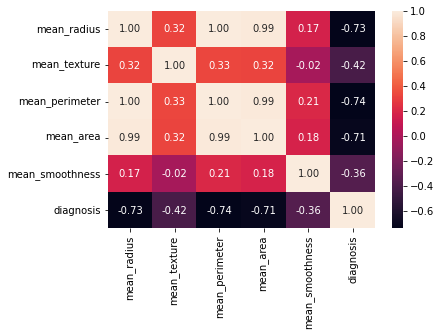

time: 495 ms (started: 2022-06-10 13:05:38 +00:00)


In [208]:
sns.heatmap(df.corr(),annot=True,fmt=".2f")